## Transfer learning & fine-tuning

* https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=ko
* [Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [3]:
import os
root_dir = "wimages/"
image_label = os.listdir(root_dir)
image_label.remove("test.csv")
image_label

['cloudy', 'sunrise', 'rainy', 'shine', 'alien_test', 'foggy']

In [4]:
import cv2
import tqdm as tqdm


In [5]:
import glob
cloudy_path = glob.glob(f"{root_dir}/{image_label[0]}/*")
cloudy_path = sorted(cloudy_path)
plt.imread(cloudy_path[0]).shape

(400, 600, 3)

In [6]:
def img_read_resize(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (120, 120))
    return img

In [7]:

def img_folder_read(img_label):
    img_files = []
    labels = []
    wfiles = glob.glob(f"{root_dir}/{img_label}/*")
    wfiles = sorted(wfiles)
    
    for w_img in wfiles:
        try:
            img_files.append(img_read_resize(w_img))
            labels.append(img_label)
        except:
            continue
    
    return img_files, labels

img_sample, labels = img_folder_read("rainy")
len(img_sample), len(labels)

(299, 299)

In [8]:
x_train_img = []
x_test_img = []
y_train_img = []
y_test_img = []

for img_label in tqdm.tqdm(image_label):
 
    x_temp, y_temp = img_folder_read(img_label)
    
    if img_label == "alien_test":
        x_test_img.extend(x_temp)
        y_test_img.extend(y_temp)
    else:
        x_train_img.extend(x_temp)
        y_train_img.extend(y_temp)
        
        
len(x_train_img), len(y_train_img), len(x_test_img), len(y_test_img)

100% 6/6 [00:07<00:00,  1.30s/it]


(1498, 1498, 30, 30)

In [9]:
x_train_img = np.array(x_train_img)
x_test_img = np.array(x_test_img)
y_train_img = np.array(y_train_img)
y_test_img = np.array(y_test_img)

x_train_img.shape, x_test_img.shape, y_train_img.shape, y_test_img.shape

((1498, 120, 120, 3), (30, 120, 120, 3), (1498,), (30,))

In [10]:
from sklearn.model_selection import train_test_split

x_train_raw, x_valid_raw, y_train_raw, y_valid_raw = train_test_split(
    x_train_img, y_train_img, test_size=0.2, random_state=42, stratify=y_train_img)

x_train_raw.shape, x_valid_raw.shape, y_train_raw.shape, y_valid_raw.shape

((1198, 120, 120, 3), (300, 120, 120, 3), (1198,), (300,))

In [11]:
x_train = x_train_raw / 255
x_valid = x_valid_raw / 255
x_test = x_test_img /255

x_train.shape, x_valid.shape, x_test.shape

((1198, 120, 120, 3), (300, 120, 120, 3), (30, 120, 120, 3))

In [12]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train_raw)
y_valid = lb.transform(y_valid_raw)

y_train.shape, y_valid.shape

((1198, 5), (300, 5))

In [13]:
x_train.shape, x_valid.shape, x_test.shape

((1198, 120, 120, 3), (300, 120, 120, 3), (30, 120, 120, 3))

In [14]:
y_train.shape, y_valid.shape, y_valid.shape

((1198, 5), (300, 5), (300, 5))

## model

* https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=ko
* [Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/)

In [15]:
x_train[0].shape

(120, 120, 3)

In [16]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg = VGG19(include_top=False, weights='imagenet', input_shape=x_train[0].shape)
vgg

2022-07-13 07:41:45.226241: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 07:41:46.924465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1185 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:21:00.0, compute capability: 8.6


In [17]:
for layer in vgg.layers:
    layer.trainable = False

```python
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(5, activation="softmax"))
```

In [18]:
num_class = len(y_train[0])
num_class

5

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(num_class, activation="softmax"))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 5)                 23045     
                                                                 
Total params: 20,047,429
Trainable params: 23,045
Non-trainable params: 20,024,384
_________________________________________________________________


```python
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)
```

In [24]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             save_weights_only=False)
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1)

In [46]:
# fit
history = model.fit(x_train, y_train, epochs=100, 
                    validation_data=(x_valid, y_valid), batch_size=32, 
                    callbacks=[checkpoint, earlystop])

Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 0.1035 - accuracy: 0.9789
Epoch 00001: val_accuracy improved from -inf to 0.87667, saving model to vgg19.h5
38/38 [==============================] - 6s 101ms/step - loss: 0.1045 - accuracy: 0.9783 - val_loss: 0.3278 - val_accuracy: 0.8767
Epoch 2/100
37/38 [============================>.] - ETA: 0s - loss: 0.1002 - accuracy: 0.9823
Epoch 00002: val_accuracy improved from 0.87667 to 0.88000, saving model to vgg19.h5
38/38 [==============================] - 3s 89ms/step - loss: 0.0998 - accuracy: 0.9825 - val_loss: 0.3374 - val_accuracy: 0.8800
Epoch 3/100
37/38 [============================>.] - ETA: 0s - loss: 0.0974 - accuracy: 0.9848
Epoch 00003: val_accuracy improved from 0.88000 to 0.88667, saving model to vgg19.h5
38/38 [==============================] - 3s 89ms/step - loss: 0.0971 - accuracy: 0.9850 - val_loss: 0.3217 - val_accuracy: 0.8867
Epoch 4/100
37/38 [============================>.] - ETA: 0s - loss: 0.0

<AxesSubplot:>

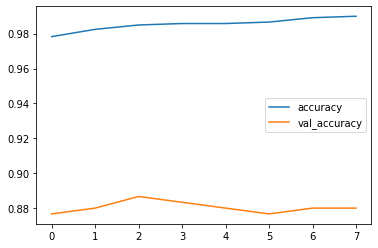

In [48]:
pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot()

In [49]:
y_pred = model.predict(x_test)

In [50]:
y_predict = np.argmax(y_pred, axis=1)
y_predict

array([0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 4, 1, 2, 4, 2, 2, 2, 2, 2, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4])

In [51]:
test = pd.read_csv("wimages/test.csv")
y_test = test["labels"]

In [52]:
accuracy = (y_predict == y_test).mean()
accuracy

0.8666666666666667

accuracy :  0.8666666666666667


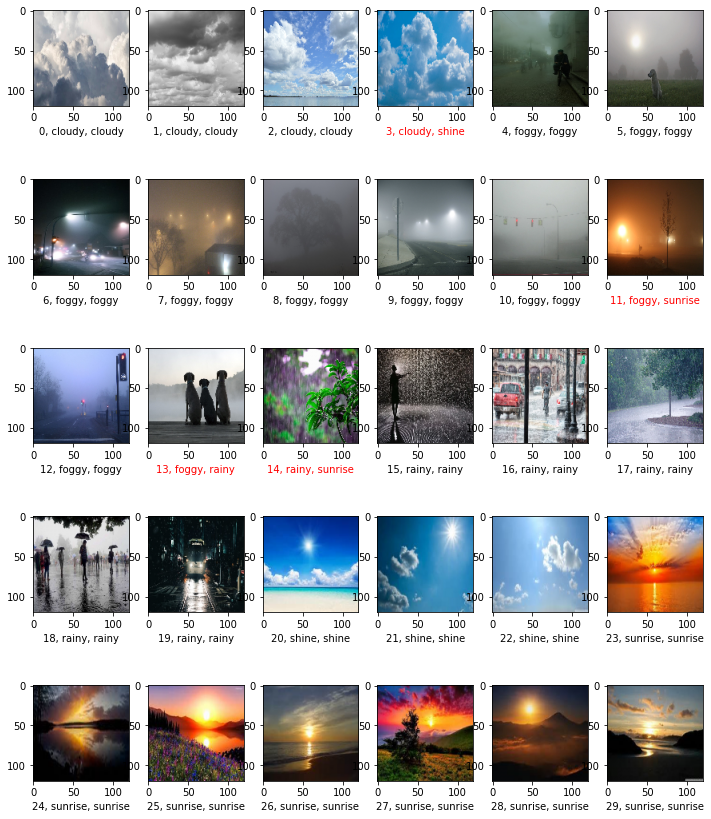

In [53]:
plt.figure(figsize=(12, 15))
print("accuracy : ", accuracy)
for i, row in test.iterrows():
    plt.subplot(5, 6, i+1)
    plt.imshow(x_test[i])
    test_label = lb.classes_[row['labels']]
    predict_label = lb.classes_[y_predict[i]]
    c = "k"
    if predict_label != test_label:
        c = "r"
    plt.xlabel(f"{i}, {test_label}, {predict_label}", c=c)